Experiment E1-3:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 256
- EPOCHS = 20
- criterion = nn.BCEWithLogitsLoss()
- optimizer = SGD
- lr=1.0e-3

model:
- self.base_model(x)
- self.globalavg(x) # (1,1)
- self.flatten(x)
- self.fc(x)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-3"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 20
config.LEARNING_RATE = 1e-3

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((1, 1))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/20
  Train Loss: 0.6606 | Train Acc: 0.6077
  Val Loss  : 0.6260 | Val Acc: 0.6920
  Train Precision: 0.6102 | Recall: 0.7797 | F1: 0.6846 | ROC AUC: 0.6428
  Train Confusion Matrix: TN=637, FP=952, FN=421, TP=1490
  Val Precision: 0.6667 | Recall: 0.8718 | F1: 0.7556 | ROC AUC: 0.7419
  Val Confusion Matrix: TN=324, FP=357, FN=105, TP=714
2
Epoch 2/20
  Train Loss: 0.6059 | Train Acc: 0.7017
  Val Loss  : 0.5833 | Val Acc: 0.7327
  Train Precision: 0.6794 | Recall: 0.8592 | F1: 0.7588 | ROC AUC: 0.7630
  Train Confusion Matrix: TN=814, FP=775, FN=269, TP=1642
  Val Precision: 0.7078 | Recall: 0.8694 | F1: 0.7803 | ROC AUC: 0.8043
  Val Confusion Matrix: TN=387, FP=294, FN=107, TP=712
3
Epoch 3/20
  Train Loss: 0.5741 | Train Acc: 0.7211
  Val Loss  : 0.5541 | Val Acc: 0.7353
  Train Precision: 0.7030 | Recall: 0.8472 | F1: 0.7684 | ROC AUC: 0.8003
  Train Confusion Matrix: TN=905, FP=684, FN=292, TP=1619
  Val Precision: 0.6983 | Recall: 0.9072 | F1: 0.7892 | ROC AUC: 0.8281

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.660597,0.607714,0.610156,0.779696,0.684585,0.642816,"{'tn': 637, 'fp': 952, 'fn': 421, 'tp': 1490}",0.626013,0.692000,0.666667,...,0.741907,"{'tn': 324, 'fp': 357, 'fn': 105, 'tp': 714}",637,952,421,1490,324,357,105,714
1,0.605901,0.701714,0.679355,0.859236,0.758780,0.763035,"{'tn': 814, 'fp': 775, 'fn': 269, 'tp': 1642}",0.583342,0.732667,0.707753,...,0.804331,"{'tn': 387, 'fp': 294, 'fn': 107, 'tp': 712}",814,775,269,1642,387,294,107,712
2,0.574121,0.721143,0.702996,0.847200,0.768391,0.800345,"{'tn': 905, 'fp': 684, 'fn': 292, 'tp': 1619}",0.554128,0.735333,0.698308,...,0.828111,"{'tn': 360, 'fp': 321, 'fn': 76, 'tp': 743}",905,684,292,1619,360,321,76,743
3,0.546490,0.747429,0.722391,0.872841,0.790521,0.826297,"{'tn': 948, 'fp': 641, 'fn': 243, 'tp': 1668}",0.528399,0.759333,0.725838,...,0.847463,"{'tn': 403, 'fp': 278, 'fn': 83, 'tp': 736}",948,641,243,1668,403,278,83,736
4,0.530459,0.747143,0.727394,0.858713,0.787617,0.838198,"{'tn': 974, 'fp': 615, 'fn': 270, 'tp': 1641}",0.517763,0.762667,0.724976,...,0.856141,"{'tn': 398, 'fp': 283, 'fn': 73, 'tp': 746}",974,615,270,1641,398,283,73,746
5,0.517912,0.756286,0.742661,0.847200,0.791494,0.843617,"{'tn': 1028, 'fp': 561, 'fn': 292, 'tp': 1619}",0.504001,0.775333,0.738614,...,0.863714,"{'tn': 417, 'fp': 264, 'fn': 73, 'tp': 746}",1028,561,292,1619,417,264,73,746
6,0.508908,0.761714,0.743115,0.861329,0.797867,0.847503,"{'tn': 1020, 'fp': 569, 'fn': 265, 'tp': 1646}",0.493819,0.782667,0.758115,...,0.870850,"{'tn': 450, 'fp': 231, 'fn': 95, 'tp': 724}",1020,569,265,1646,450,231,95,724
7,0.494538,0.771143,0.756707,0.856096,0.803339,0.861254,"{'tn': 1063, 'fp': 526, 'fn': 275, 'tp': 1636}",0.485702,0.784000,0.746269,...,0.873694,"{'tn': 426, 'fp': 255, 'fn': 69, 'tp': 750}",1063,526,275,1636,426,255,69,750
8,0.486868,0.778286,0.762610,0.862376,0.809430,0.863843,"{'tn': 1076, 'fp': 513, 'fn': 263, 'tp': 1648}",0.472515,0.794000,0.771855,...,0.878922,"{'tn': 467, 'fp': 214, 'fn': 95, 'tp': 724}",1076,513,263,1648,467,214,95,724
9,0.478215,0.786286,0.773647,0.860283,0.814668,0.869989,"{'tn': 1108, 'fp': 481, 'fn': 267, 'tp': 1644}",0.465346,0.798667,0.782514,...,0.880758,"{'tn': 482, 'fp': 199, 'fn': 103, 'tp': 716}",1108,481,267,1644,482,199,103,716


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.626013  0.692000       0.666667    0.871795  0.755556    0.741907
1   0.583342  0.732667       0.707753    0.869353  0.780274    0.804331
2   0.554128  0.735333       0.698308    0.907204  0.789166    0.828111
3   0.528399  0.759333       0.725838    0.898657  0.803055    0.847463
4   0.517763  0.762667       0.724976    0.910867  0.807359    0.856141
5   0.504001  0.775333       0.738614    0.910867  0.815746    0.863714
6   0.493819  0.782667       0.758115    0.884005  0.816234    0.870850
7   0.485702  0.784000       0.746269    0.915751  0.822368    0.873694
8   0.472515  0.794000       0.771855    0.884005  0.824132    0.878922
9   0.465346  0.798667       0.782514    0.874237  0.825836    0.880758
10  0.461074  0.804000       0.795276    0.863248  0.827869    0.883731
11  0.455337  0.800000       0.772298    0.898657  0.830700    0.887720
12  0.451345  0.805333       0.793103    0.870574  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.496375,0.767414,0.755543,0.854055,0.801249,0.848784,0.482651,0.784433,0.761007,0.887363,0.818600,0.868709,1053.850000,535.150000,278.900000,1632.100000,449.900000,231.100000,92.250000,726.750000
std,0.060857,0.047360,0.048255,0.018809,0.033782,0.058409,0.055128,0.032973,0.039448,0.017520,0.021857,0.039009,140.514946,140.514946,35.944255,35.944255,53.290564,53.290564,14.348574,14.348574
min,0.436401,0.607714,0.610156,0.779696,0.684585,0.642816,0.425575,0.692000,0.666667,0.858364,0.755556,0.741907,637.000000,398.000000,243.000000,1490.000000,324.000000,166.000000,69.000000,703.000000
25%,0.448863,0.754071,0.738844,0.850602,0.791250,0.842262,0.441606,0.772167,0.735420,0.871795,0.813650,0.861821,1008.500000,440.750000,264.750000,1625.500000,413.500000,185.500000,80.250000,714.000000
50%,0.475093,0.787000,0.773018,0.858974,0.814788,0.871397,0.463210,0.796333,0.772077,0.884005,0.826653,0.882244,1104.500000,484.500000,269.500000,1641.500000,465.500000,215.500000,95.000000,724.000000
75%,0.521049,0.794786,0.787526,0.861460,0.819957,0.882352,0.507442,0.810167,0.793646,0.902015,0.833232,0.892022,1148.250000,580.500000,285.500000,1646.250000,495.500000,267.500000,105.000000,738.750000
max,0.660597,0.810857,0.805379,0.872841,0.832659,0.890465,0.626013,0.813333,0.808976,0.915751,0.838636,0.900821,1191.000000,952.000000,421.000000,1668.000000,515.000000,357.000000,116.000000,750.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   20.000000  20.000000        20.000000     20.000000  20.000000   
mean     0.496375   0.767414         0.755543      0.854055   0.801249   
std      0.060857   0.047360         0.048255      0.018809   0.033782   
min      0.436401   0.607714         0.610156      0.779696   0.684585   
25%      0.448863   0.754071         0.738844      0.850602   0.791250   
50%      0.475093   0.787000         0.773018      0.858974   0.814788   
75%      0.521049   0.794786         0.787526      0.861460   0.819957   
max      0.660597   0.810857         0.805379      0.872841   0.832659   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     20.000000  20.000000  20.000000      20.000000   20.000000   
mean       0.848784   0.482651   0.784433       0.761007    0.887363   
std        0.058409   0.055128   0.032973       0.039448    0.017520   
min        0.642816   0.425575   0.692000    

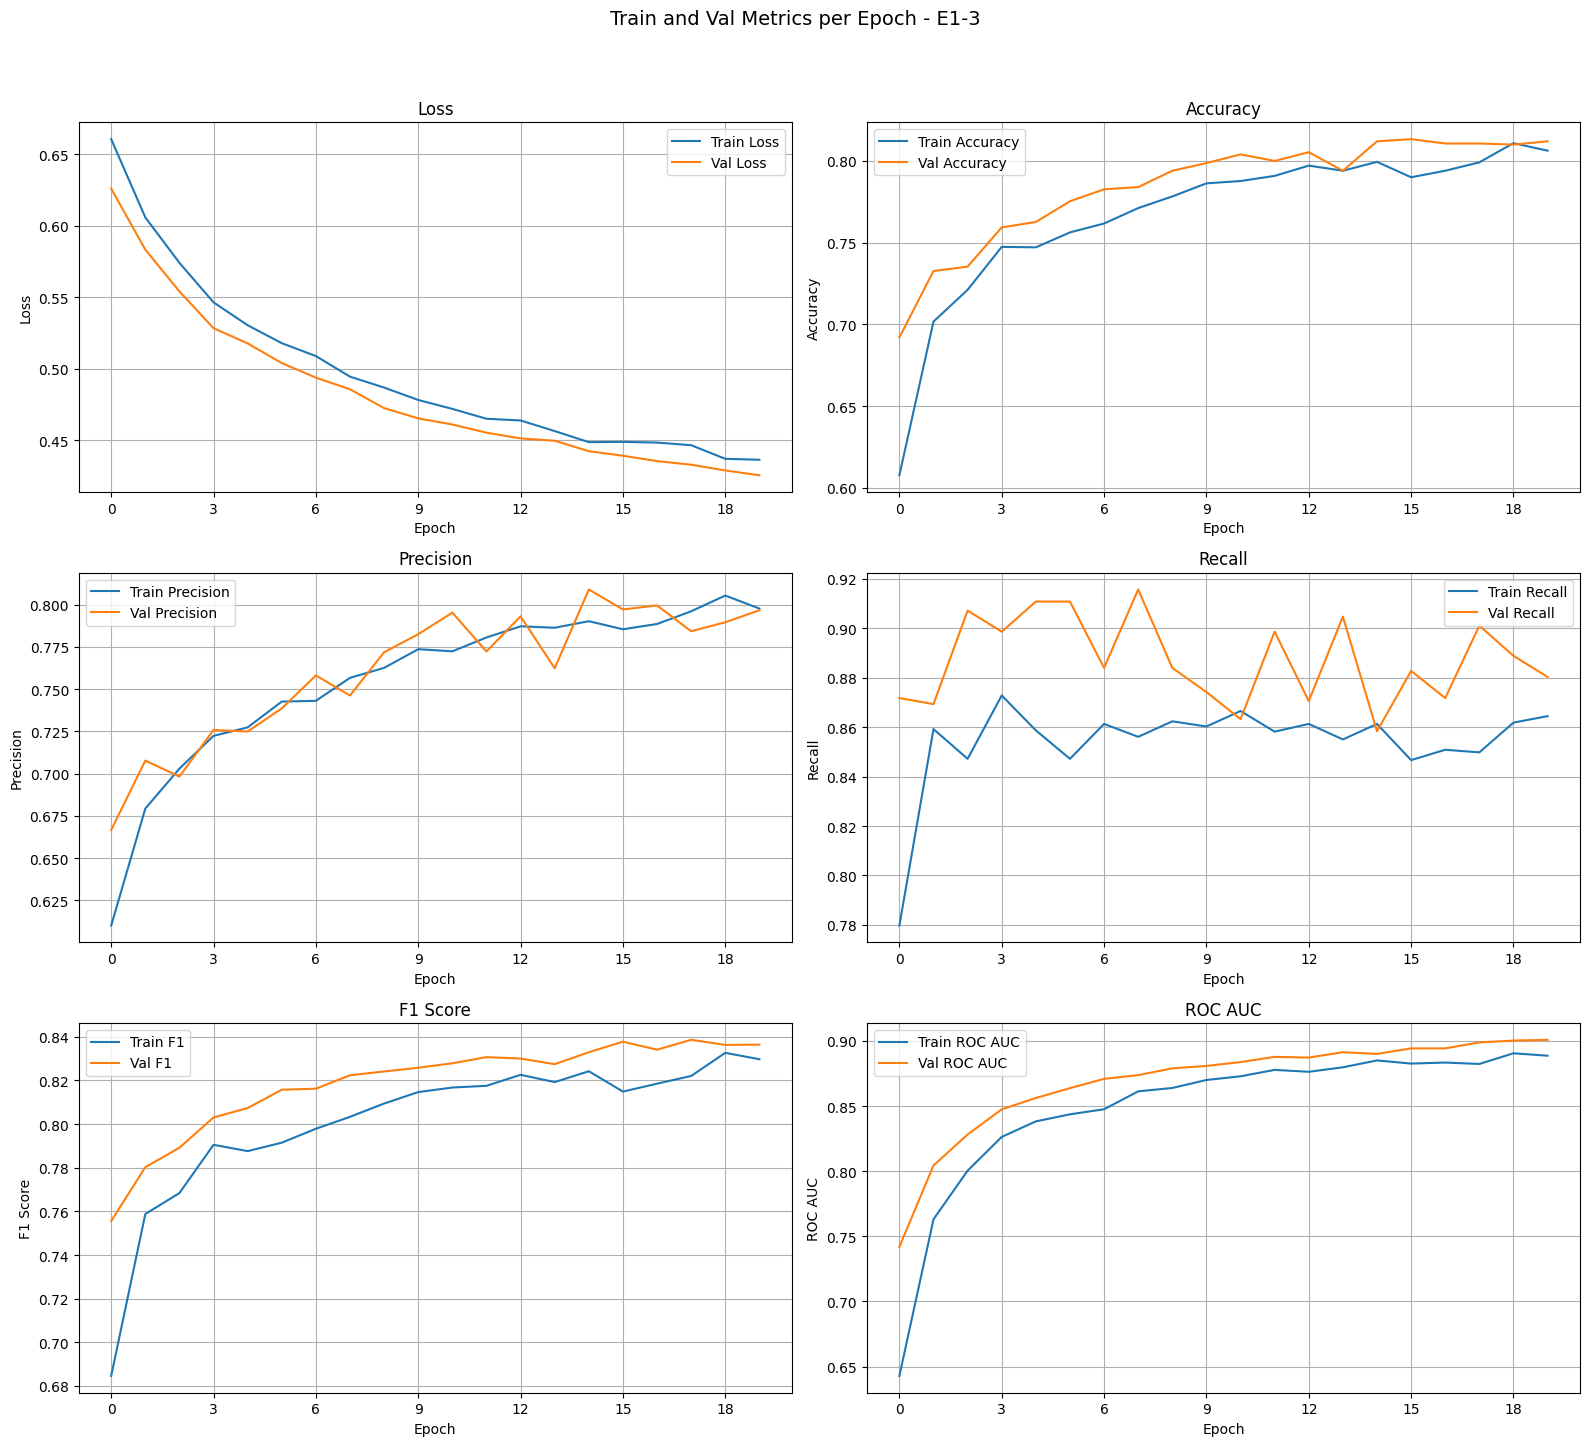

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,20.000000,20.000000,20.000000,20.000000
mean,1053.850000,535.150000,278.900000,1632.100000
std,140.514946,140.514946,35.944255,35.944255
min,637.000000,398.000000,243.000000,1490.000000
25%,1008.500000,440.750000,264.750000,1625.500000
50%,1104.500000,484.500000,269.500000,1641.500000
75%,1148.250000,580.500000,285.500000,1646.250000
max,1191.000000,952.000000,421.000000,1668.000000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000
mean,449.900000,231.100000,92.250000,726.750000
std,53.290564,53.290564,14.348574,14.348574
min,324.000000,166.000000,69.000000,703.000000
25%,413.500000,185.500000,80.250000,714.000000
50%,465.500000,215.500000,95.000000,724.000000
75%,495.500000,267.500000,105.000000,738.750000
max,515.000000,357.000000,116.000000,750.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)